<a href="https://colab.research.google.com/github/JFaberSFSD/Food_Sales_Predictions/blob/main/Sales_Predictions_Machine_Learning_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Justin Faber - Sales Predictions Project - Machine Learning Prep & Models
##June 2022


#First things first, let's import all of our libraries, and import and assign our data to a pandas dataframe

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn import set_config
set_config(display='diagram')

df = pd.read_csv('/content/drive/MyDrive/06 - Week 6 (July 25th)/Sales_Data_Final_CLEANED.csv')

df.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#You'll notice that we are importing our ALREADY CLEANED data from our previous notebook. Please refer to that notebook for the data cleaning process

##We can verify our data is ready to rock with some simple verifications. First let's double-check duplicates

In [19]:
df.duplicated().sum()

0

##Now let's check for any missing or null values

In [20]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [21]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


###Everything is looking good! Let's move onto the fun part!

#Before we split our data, and start the steps toward machine learning, let's look at all variables one last time, to determine if there are any columns that we can drop that may actually HELP our model perform better

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8519 entries, 0 to 8518
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 798.8+ KB


###It's looks to me like we can safely remove Item_Identifier (unique to each product), Outlet_Identifier (unique to each outlet) and Outlet_Establishment_Year (again, unique to each outlet). As these variables will likely only hurt our model performance

#Now that our data is in an organized and somewhat clean format, let's split into Train/Test sets, dropping the columns we identified in the previous step

In [23]:
X = df.drop(columns=['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'])
y = df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Let's create our column selectors for our different dytpes

In [24]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

#Now let's create an imputer for each of our selectors

In [25]:
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

##We will use the mean imputer for all of our numerical data, as all of them are float64 and do not need to be exact integers. (If a whole number was a requirment of our data, we would consider "median" at that point)

##We will use the most_frequent imputer for our categorical data, as this will be the easiest and fastest way to impute our categorial data with limited impact on our models

##With the cleaning steps we did earlier, we know that we shouldn't have ANY null values in our data this first time through, but creating these pipelines with simper imputers from the beginning, may help us later if we get the opportunity to ADD data into our model, with the possibility that our ADDITIONAL data may have some nulls that need to be imputed!

#After imputing our data, we will need to scale our numeric data and one-hot encode our categorical data. Let's create an instance of each

In [26]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#Each of our different dtypes will have to follow a different pipeline, so let's create one for each

In [27]:
num_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)

#We will need a tuple, with our different piplines, to feed into our column transformer, let's make one for each dtypes now

In [28]:
num_tuple = (num_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

#Now we will create our preprocessor with all pipelines in it

In [29]:
preprocessor = make_column_transformer(num_tuple, category_tuple, remainder = 'passthrough')

#Now we want to fit our column transformer on our TRAIN DATA ONLY! 

In [30]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f2c4f858790>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f2c4f858990>)])

#Now that we have created our preprocessor with our pipelines, let's transform our data!  



In [31]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [32]:
X_train_processed_df = pd.DataFrame(X_train_processed)

X_train_processed_df.head()

#preprocessed and ready to rock!! 

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.739662,-0.705576,1.837974,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.196563,1.304008,-0.281413,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.669773,0.346318,1.691163,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.013623,0.837109,1.467227,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.341497,-1.284039,-1.604467,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#With our data now preprocessed, let's first create a linear regression model 

In [37]:
#Create an instance of linear regression
lin_reg = LinearRegression()

#Fit model onto TRAINING DATA ONLY
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

#Now we will create model predictions

In [38]:
lin_reg_train_pred = lin_reg.predict(X_train_processed_df)

lin_reg_test_pred = lin_reg.predict(X_test_processed)

#To test our models on multiple metrics, let's create a function that will do this for us!

In [39]:
def eval_metrics(true, pred):
  mae = round(mean_absolute_error(true, pred),6)
  mse = round(mean_squared_error(true, pred),6)
  rmse = round(np.sqrt(mse),6)
  r2 = round(r2_score(true, pred),6)

  print(f'MAE = {mae}\nMSE = {mse}\nRMSE = {rmse}\nR^2 = {r2}')

#Now let's test our linear regression model to see how it performed

In [40]:
eval_metrics(y_test, lin_reg_test_pred)

MAE = 828.68951
MSE = 1272853.032353
RMSE = 1128.207885
R^2 = 0.557749


In [42]:
round(df['Item_Outlet_Sales'].mean(),2)

2181.19

###An R^2 of 55.77. Oofta. Not ideal. This means our model is only accounting for a little over half of the variance in our data. 

###When we look at the RMSE, we see a number of 1,128. The nice thing about RMSE is that it's in the same "units" as our test data, so we can say that we are missing the mark, on average, by around \$1,128 on each prediction. The mean of our data for outlet sales is \$2,181.19. Being off by over \$1,000 when you're comparing it to the mean, is not a great performing model. Let's go down a different pathway now and see if alternate models may provide better performance.

#For our next model, let's create a simple decision tree model to see if we can improve our performance

In [49]:
#First we must create an instance of the decision tree
dec_tree = DecisionTreeRegressor(random_state = 42)

#Now let's fit the decision tree on our TRAIN DATA ONLY
dec_tree.fit(X_train_processed, y_train)

#Now that we have fit on the training data, let's create our predictions!
dec_tree_train_preds = dec_tree.predict(X_train_processed)
dec_tree_test_preds = dec_tree.predict(X_test_processed)

#Let's call on our function again to see how well our initial model performed. We'll start with our training data
eval_metrics(y_train, dec_tree_train_preds)

MAE = 0.0
MSE = 0.0
RMSE = 0.0
R^2 = 1.0


##No surprise here, it performed exceptionally well on our training data, which is to be expected. Let's check our test data.

In [50]:
eval_metrics(y_test, dec_tree_test_preds)

MAE = 1059.962352
MSE = 2328307.457392
RMSE = 1525.879241
R^2 = 0.191032


##Yikes! An R^2 of just 19.10. This tells us, beyond a shadow of a doubt, that our model is over-fitting to our training data. To explore this further and come up with possible solutions, let's check the depth and leaves of our tree first.

In [51]:
depth = dec_tree.get_depth()
leaves = dec_tree.get_n_leaves()
print(f'Depth = {depth} \nLeaves = {leaves}')

Depth = 36 
Leaves = 6270


###That's quite deep, with quite a few leaves. This is likely the reason that our model is over-fitting. Let's create a for-loop to cycle through different depths for our tree, to see if we can find a sweet spot between variance and bias. 

In [57]:
depths = list(range(2, 36))

dec_tree_scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree_2 = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree_2.fit(X_train_processed, y_train)
    train_score = dec_tree_2.score(X_train_processed, y_train)
    test_score = dec_tree_2.score(X_test_processed, y_test)
    dec_tree_scores.loc[depth, 'Train Score'] = train_score
    dec_tree_scores.loc[depth, 'Test Score'] = test_score


#Let's sort our scores in descending order and take a look at the top 5
sorted_scores = dec_tree_scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()  

,Test Score,Train Score
5,0.596758,0.604997
6,0.579535,0.617524
4,0.577786,0.585749
7,0.559949,0.631655
8,0.553524,0.648516


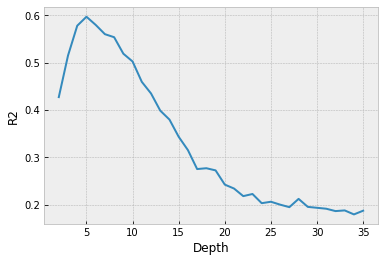

In [54]:
#We can create a quick visualization of this as well to better understand our results
plt.style.use('bmh')
plt.plot(depths, dec_tree_scores['Test Score'])
plt.xlabel('Depth')
plt.ylabel('R2');

###This is very helpful. It clearly shows that the deeper our tree gets, the worse it's performance becomes, and significantly so. A depth of 5 provides our highest R^2 score, so let's adjust our model to that depth, and fun our function again to see our other metrics!

In [58]:
dec_tree_FINAL = DecisionTreeRegressor(random_state = 42,max_depth=5)

dec_tree_FINAL.fit(X_train_processed, y_train)

dec_tree_FINAL_train_preds = dec_tree_FINAL.predict(X_train_processed)
dec_tree_FINAL_test_preds = dec_tree_FINAL.predict(X_test_processed)

eval_metrics(y_test, dec_tree_FINAL_test_preds)

MAE = 750.926557
MSE = 1160578.723775
RMSE = 1077.301594
R^2 = 0.596758


###We are slowly but surely improving our results. Our decision tree model is showing an R^2 of 59.68, which means that it accounts for a handful of percentage points more of the variance in our data than the linear regression model did. Our RMSE is 1,077, which isn't a huge improvement over the RMSE of 1,128 that we had with our linear regression model. This tells me we need to keep searching! 

#I'm interested to try a random forest model on our data, so let's check that out next!

In [59]:
#First let's create an instance for a random forest
rf = RandomForestRegressor(random_state = 42)

#Now we will fit it on our TRAIN DATA ONLY
rf.fit(X_train_processed, y_train)

#Now we will create our predictions, and call our function again to see the results!
rf_train_pred = rf.predict(X_train_processed)
rf_test_pred = rf.predict(X_test_processed)

eval_metrics(y_test, rf_test_pred)

MAE = 801.061893
MSE = 1352140.558586
RMSE = 1162.815789
R^2 = 0.5302


##Not amazing to start, with an R^2 of just 53.02, but this is just a STARTING point! We can further tune our model to increase performance!

##For starters, let's check the depth of our model

In [60]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

45

##Fairly deep. Perhaps that's impacting performance. Just like before, we can create a for-loop to check for variance in our models performance based on how deep it is. Let's create that now and see if we can learn more!

In [62]:
rf_depths = range(1, max(est_depths))
rf_2_scores = pd.DataFrame(index=rf_depths, columns=['Test Score','Train Score'])
for depth in rf_depths:    
   rf_2 = RandomForestRegressor(max_depth=depth, random_state=42)
   rf_2.fit(X_train_processed, y_train)
   rf_2_scores.loc[depth, 'Train Score'] = rf_2.score(X_train_processed, y_train)
   rf_2_scores.loc[depth, 'Test Score'] = rf_2.score(X_test_processed, y_test)


#Again, we will sort our scores in descending order and take a look at the top 5
rf_sorted_scores = rf_2_scores.sort_values(by='Test Score', ascending=False)
rf_sorted_scores.head() 

,Test Score,Train Score
5,0.596772,0.614016
6,0.595067,0.628257
7,0.591958,0.646031
8,0.587972,0.667658
4,0.587202,0.59767


##Improvement! With a max_depth of 5 we are continuing our climb toward that R^2 of 60! There are some additional hyperparameters that we can tweak, so let's set our model permanently to that max depth of 5 and see what else we can do for improvement!

#The next hyperparameter that might help us, is the number of estimators within our random forests model. This is expressed as "n_estimators". Let's create another for-loop to see if we can find any improvement on this front. 

In [63]:
rf_estimators = [25, 50, 100, 150, 200, 250, 300, 350, 400]
rf_scores_3 = pd.DataFrame(index=rf_estimators, columns=['Test Score','Train Score'])
for estimators in rf_estimators:    
   rf_3 = RandomForestRegressor(max_depth = 5, n_estimators=estimators, random_state = 42)
   rf_3.fit(X_train_processed, y_train)
   rf_scores_3.loc[estimators, 'Train Score'] = rf_3.score(X_train_processed, y_train)
   rf_scores_3.loc[estimators, 'Test Score'] = rf_3.score(X_test_processed, y_test)


#Again, we will sort our scores in descending order and take a look at the top 5
rf_sorted_scores_3 = rf_scores_3.sort_values(by='Test Score', ascending=False)
rf_sorted_scores_3.head() 

,Test Score,Train Score
150,0.597646,0.614064
250,0.597412,0.613939
300,0.597393,0.613953
400,0.597271,0.613833
350,0.59727,0.61388


##It's small moves, but moves in the right direction! Looks like 150 estimators is the sweet spot!

In [64]:
#Let's create a new instance of the random forest, this time with our final hyperparameters for our top performing model
final_rf = RandomForestRegressor(max_depth=5, n_estimators=150, random_state = 42)

#Now we will fit it on our TRAIN DATA ONLY
final_rf.fit(X_train_processed, y_train)

#One final set of predictions, and one final call on our functions to see the metrics!
final_rf_train_pred = final_rf.predict(X_train_processed)
final_rf_test_pred = final_rf.predict(X_test_processed)

eval_metrics(y_test, final_rf_test_pred)

MAE = 747.67193
MSE = 1158023.515883
RMSE = 1076.115011
R^2 = 0.597646


#Let's call on each of the three final models that we created, so we can compare and choose a final model to move foward with!

In [68]:
print("Linear Regression Model")
eval_metrics(y_test, lin_reg_test_pred)

Linear Regression Model
MAE = 828.68951
MSE = 1272853.032353
RMSE = 1128.207885
R^2 = 0.557749


In [69]:
print("Simple Decision Tree Model")
eval_metrics(y_test, dec_tree_FINAL_test_preds)

Simple Decision Tree Model
MAE = 750.926557
MSE = 1160578.723775
RMSE = 1077.301594
R^2 = 0.596758


In [70]:
print("Random Forest Model")
eval_metrics(y_test, final_rf_test_pred)

Random Forest Model
MAE = 747.67193
MSE = 1158023.515883
RMSE = 1076.115011
R^2 = 0.597646


#When compared side-by-side, we have a clear winner! The Random Forest Model. 

#Not only was it our highest scoring R^2 model, it ALSO performed the best in every other metric we have, with an MAE of 747.67, an MSE of 1158023.52 and an RMSE of 1076.12